# 10720PHYS401200 Homework-5

## References:
* PRB 81, 174411 (2010).
* PRB 86, 045139 (2012).

In [3]:
import Tor10
import copy as cp
import numpy as np
import matplotlib.pyplot as plt

## Problem 1: SVD-truncate for a rank-4 tensor
Write a function to perform the SVD-turncate for a rank-4 tensor. 

In [4]:
def SVD_truncate(T, D_remain):
    M = T.GetBlock()
    M.SetName('M')
    
    # SVD_truncate with UniTensor method
    UM, S, VtM = M.Svd_truncate(int(D_remain))
    UM.SetName('UM')
    S.SetName('S')
    VtM.SetName('VtM')
    print(S)
    
    rowrank = T.rowrank
    rank = len(T.labels)
    colrank = rank - rowrank
    
    # Duplicate labels from UM and VtM
    U_labels = np.concatenate([T.labels[:rowrank],UM.labels[-1:]])
    Vt_labels = np.concatenate([VtM.labels[:1], T.labels[-colrank:]])
    
    # Duplicate bonds from UM and VtM
    U_bonds = np.concatenate([T.bonds[:rowrank],UM.bonds[-1:]])
    Vt_bonds = np.concatenate([VtM.bonds[:1], T.bonds[-colrank:]])
    
    # Put UM values to U shape tensor
    U = Tor10.UniTensor(bonds=U_bonds, labels=U_labels, rowrank=T.rowrank, name='U') 
    U.PutBlock(UM)
    
    # Put VtM values to Vt shape tensor
    Vt = Tor10.UniTensor(bonds=Vt_bonds, labels=Vt_labels, rowrank=1, name='Vt')
    Vt.PutBlock(VtM)
    
    T.Print_diagram()
    U.Print_diagram()
    S.Print_diagram()
    Vt.Print_diagram()
    
    return U, S, Vt

### TEST - Input a random Rank-4 tensor

In [5]:
bd = Tor10.Bond(2)
R4T = Tor10.UniTensor([bd, bd, bd, bd], rowrank=2, name='R4T', labels=[10,11,12,13])
_ = R4T.Rand()
R4T.Print_diagram()

-----------------------
tensor Name : R4T
tensor Rank : 4
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
    10 ____| 2         2 |____ 12 
           |             |     
    11 ____| 2         2 |____ 13 
           \             /     
            -------------      


In [6]:
U, S, V = SVD_truncate(R4T, 4)

Tensor name: S
is_diag    : True
tensor([2.0600, 0.7601, 0.1388, 0.0742], dtype=torch.float64)

-----------------------
tensor Name : R4T
tensor Rank : 4
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
    10 ____| 2         2 |____ 12 
           |             |     
    11 ____| 2         2 |____ 13 
           \             /     
            -------------      
-----------------------
tensor Name : U
tensor Rank : 3
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
    10 ____| 2         4 |____ -1 
           |             |     
    11 ____| 2           |        
           \             /     
            -------------      
-----------------------
tensor Name : S
tensor Rank : 2
has_symmetry: False
on device     : cpu
is_diag       : True
            -------------      
           /             \     
    -1 ____| 4         4 

## Problem 2: HOSVD for a rank-4 tensor
Write a function to perform higer-order SVD for a rank-4 tensor. 
That is, given a rank-4 tensor $M_{abcd}$, find unitary matrices $U^L, U^R, U^U, U^D$ such that
$$
  \large
  M_{abcd} = \sum_{ijkl} S_{ijkl} U^L_{ai} U^R_{bj} U^U_{ck} U^{D}_{dl},
$$
where $S$ is the core tensor.

In [7]:
def Find_unitary(T, label_list):
    print('\n----Find Unitary Matrices----\n')
    index_list  = cp.deepcopy(label_list)
    U_list = []
    for i in range(len(T.labels)):
        MP_label = []
        MP_label.append(label_list[i])
        for label in label_list:
            if label != label_list[i]:
                MP_label.append(label)
        M = cp.deepcopy(T)
        MP = M.Permute(MP_label, rowrank=1)
        MP.SetName('MP')
        MPt = MP.Whole_transpose()
        MPt.SetLabel(9999, 3)
        MM = Tor10.Contract(MP, MPt)
        u, s, vt = MM.Svd()
        u.SetLabel(int(u.labels[0])+10, 1)
        U_list.append(u)
    return U_list

def Print_diagram(T_list):
    for T in T_list:
        print(T.Print_diagram())

def Check_unitary(U_list):
    print('\n----Check Unitary----\n')
    for U in U_list:
        U = cp.deepcopy(U)
        Ut = U.Whole_transpose()
        U.SetLabels([0, -1])
        Ut.SetLabels([-1, 1])
        print(Tor10.Contract(Ut, U))
        print(Tor10.Contract(U, Ut)) 

### TEST - Input a random Rank-4 tensor

In [12]:
bd = Tor10.Bond(2)
R4T = Tor10.UniTensor([bd, bd, bd, bd], rowrank=2, name='R4T')
_ = R4T.Rand()
R4T.Print_diagram()
print(R4T)

-----------------------
tensor Name : R4T
tensor Rank : 4
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
     0 ____| 2         2 |____ 2  
           |             |     
     1 ____| 2         2 |____ 3  
           \             /     
            -------------      
Tensor name: R4T
is_diag    : False
tensor([[[[0.5884, 0.3148],
          [0.7116, 0.1235]],

         [[0.1531, 0.8536],
          [0.0954, 0.6619]]],


        [[[0.3400, 0.7777],
          [0.2391, 0.1860]],

         [[0.4343, 0.9612],
          [0.3753, 0.5977]]]], dtype=torch.float64)



In [13]:
U_list = Find_unitary(R4T, [0,1,2,3])
_ = Print_diagram(U_list)
Check_unitary(U_list)


----Find Unitary Matrices----

-----------------------
tensor Name : 
tensor Rank : 2
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
     0 ____| 2         2 |____ 10 
           \             /     
            -------------      
None
-----------------------
tensor Name : 
tensor Rank : 2
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
     1 ____| 2         2 |____ 11 
           \             /     
            -------------      
None
-----------------------
tensor Name : 
tensor Rank : 2
has_symmetry: False
on device     : cpu
is_diag       : False
            -------------      
           /             \     
     2 ____| 2         2 |____ 12 
           \             /     
            -------------      
None
-----------------------
tensor Name : 
tensor Rank : 2
has_symmetry: False
on device     : cpu
is_diag       : Fa

## Problem 3: 2x2 Ising model

Consider 2D Ising model $H=-\sum_{\langle ij\rangle} \sigma^z_i \sigma^z_j$ on square lattice. By contracting the 2x2 tensor network, plot 
* energy per site,
* $C_v$ per site,
* $C_{max}=\langle S_{1,1,} S_{2,2}\rangle$,
* $dC_{max}/dT$,
as a function of temperature.

In [14]:
def Ising_NT_Contract(Temp):
    
    # variable
    beta = 1/Temp
    
    # bond
    bd = Tor10.Bond(2)
    
    # W
    W = Tor10.UniTensor([bd,bd],rowrank=1)
    W.SetName('W')
    W.SetElem([np.sqrt(np.cosh(beta)), np.sqrt(np.sinh(beta)),
               np.sqrt(np.cosh(beta)), -np.sqrt(np.sinh(beta))])

    # T and Tz
    T = Tor10.UniTensor([bd,bd,bd,bd],rowrank=2, name='T')
    Tz = Tor10.UniTensor([bd,bd,bd,bd],rowrank=2, name='Tz')
    for i in range(2):
        for j in range(2):
            for k in range(2):
                for l in range(2):
                    T[i,j,k,l] = W[0,i].item()*W[0,j].item()*W[0,k].item()*W[0,l].item() + W[1,i].item()*W[1,j].item()*W[1,k].item()*W[1,l].item()     
                    Tz[i,j,k,l] = W[0,i].item()*W[0,j].item()*W[0,k].item()*W[0,l].item() - W[1,i].item()*W[1,j].item()*W[1,k].item()*W[1,l].item()     

# Trace
#     T11 : 0 1; 3 4
#     T12 : 2 3; 1 6
#     T21 : 4 5; 7 0
#     T22 : 6 7; 5 2
        
    # Z
    T11 = cp.deepcopy(T)
    T12 = cp.deepcopy(T)
    T21 = cp.deepcopy(T)
    T22 = cp.deepcopy(T)

    T11.SetLabels([0,1,3,4])
    T12.SetLabels([2,3,1,6])
    T21.SetLabels([4,5,7,0])
    T22.SetLabels([6,7,5,2])

    Z = Tor10.Contract(Tor10.Contract(T11, T12), Tor10.Contract(T21, T22))
    Z = Z.item()

    # SzSz
    T11 = cp.deepcopy(Tz)
    T12 = cp.deepcopy(Tz)
    T21 = cp.deepcopy(T)
    T22 = cp.deepcopy(T)

    T11.SetLabels([0,1,3,4])
    T12.SetLabels([2,3,1,6])
    T21.SetLabels([4,5,7,0])
    T22.SetLabels([6,7,5,2])

    SzSz = Tor10.Contract(Tor10.Contract(T11, T12), Tor10.Contract(T21, T22))
    SzSz = SzSz.item()
    
    # Cmax
    T11 = cp.deepcopy(Tz)
    T12 = cp.deepcopy(T)
    T21 = cp.deepcopy(T)
    T22 = cp.deepcopy(Tz)

    T11.SetLabels([0,1,3,4])
    T12.SetLabels([2,3,1,6])
    T21.SetLabels([4,5,7,0])
    T22.SetLabels([6,7,5,2])

    Cmax = Tor10.Contract(Tor10.Contract(T11, T12), Tor10.Contract(T21, T22))
    Cmax = Cmax.item()

    return Z, SzSz, Cmax

In [15]:
T_list = np.linspace(0.5, 5.0, 450, endpoint=True)

Z_list, SzSz_list, Cmax_list = [], [], []
for temp in T_list:
    Z, SzSz, Cmax = Ising_NT_Contract(temp)
    Z_list.append(Z)
    SzSz_list.append(SzSz)
    Cmax_list.append(Cmax)

In [24]:
L = 2
N = L ** 2
Tc = 2/np.log(1+np.sqrt(2))
Temp = np.array(T_list)

Z = np.array(Z_list)
E_per_site = np.array(SzSz_list) * (-1 / Z) 
C_per_site = np.gradient(E_per_site, Temp) / N
C_max = np.array(Cmax_list) / Z
dC_dT = -np.gradient(C_max, Temp) / N

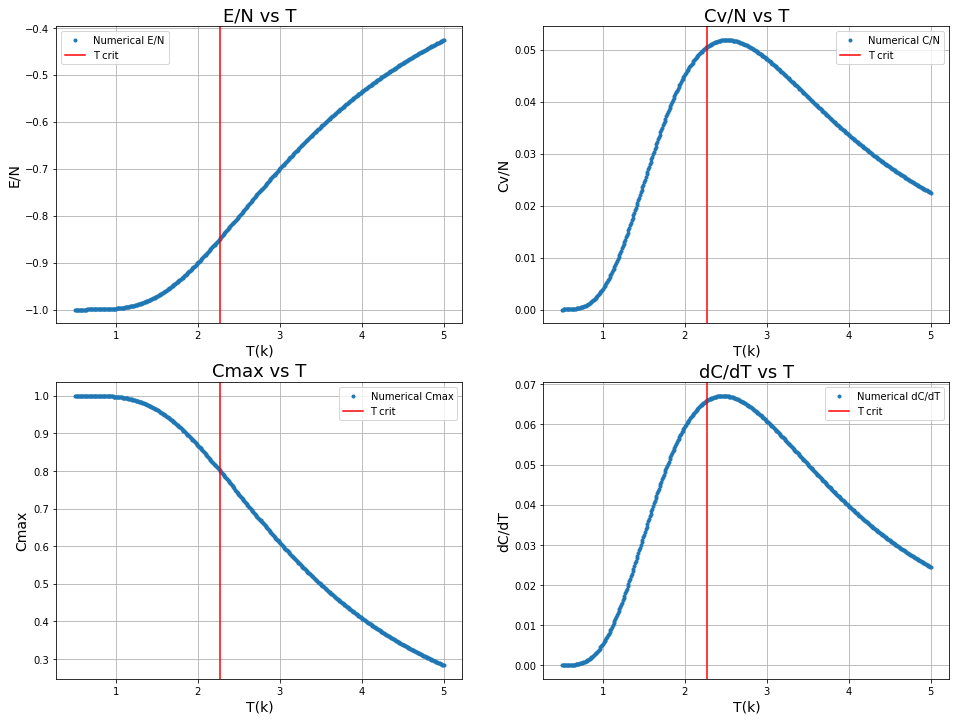

In [25]:
plt.figure(figsize=(16, 12))

# Energy per site
plt.subplot(2, 2, 1)
plt.plot(Temp, E_per_site, '.', label = 'Numerical E/N')
plt.axvline(Tc, color='red', label = 'T crit')
plt.title('E/N vs T', fontsize=18)
plt.xlabel('T(k)', fontsize=14)
plt.ylabel('E/N', fontsize=14)
plt.legend()
plt.grid()

# Capacity per site
plt.subplot(2, 2, 2)
plt.plot(Temp, C_per_site, '.', label = 'Numerical C/N')
plt.axvline(Tc, color='red', label = 'T crit')
plt.title('Cv/N vs T', fontsize=18)
plt.xlabel('T(k)', fontsize=14)
plt.ylabel('Cv/N', fontsize=14)
plt.legend()
plt.grid()

# Cmax
plt.subplot(2, 2, 3)
plt.plot(Temp, C_max, '.', label = 'Numerical Cmax')
plt.axvline(Tc, color='red', label = 'T crit')
plt.title('Cmax vs T', fontsize=18)
plt.xlabel('T(k)', fontsize=14)
plt.ylabel('Cmax', fontsize=14)
plt.legend()
plt.grid()

# dC/dT
plt.subplot(2, 2, 4)
plt.plot(Temp, dC_dT, '.', label = 'Numerical dC/dT')
plt.axvline(Tc, color='red', label = 'T crit')
plt.title('dC/dT vs T', fontsize=18)
plt.xlabel('T(k)', fontsize=14)
plt.ylabel('dC/dT', fontsize=14)
plt.legend()
plt.grid()

plt.show()

## Problem 4 (Bonus): 4x4 Ising model

Perform higher-order TRG to coarse grain a 4x4 tensor network into a 2x2 tensor network. By contracting the (effective) 2x2 tensor network, plot 
* energy per site,
* $C_v$ per site,
* $C_{max}=\langle S_{1,1,} S_{2,2}\rangle$,
* $dC_{max}/dT$,
as a function of temperature.

Try 8x8 lattice or even larger $2^n \times 2^n$ lattice.